In [30]:
import scipy
from sklearn import svm
from sklearn import metrics
import gensim
from gensim import models
from gensim.models import CoherenceModel
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,\
                                                TfidfVectorizer

def train_predict_evaluate_model(classifier, train_features, train_labels,
                                 test_features, test_labels):
    """
    训练、预测、评估 模型
    :param classifier: 模型
    :param train_features: 训练集特征
    :param train_labels: 训练集label
    :param test_features: 测试集特征
    :param test_labels: 测试集label
    :return: 预测结果
    """
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    get_metrics(true_labels=test_labels, predicted_labels=predictions)
    return predictions

def get_metrics(true_labels, predicted_labels):
    """
    分别计算预测结果的准确率、精确率、召回率、F1值，直接打印出这些结果
    :param true_labels: 真实label
    :param predicted_labels: 预测结果
    :return:
    """
    print("accuracy:", np.round(metrics.accuracy_score(true_labels,
                                                       predicted_labels), 5))
    print("precision:", np.round(metrics.precision_score(
        true_labels, predicted_labels, average='weighted'), 5))
    print("recall:", np.round(metrics.recall_score(
        true_labels, predicted_labels, average='weighted'), 5))
    print("f1 score:", np.round(metrics.f1_score(
        true_labels, predicted_labels, average='weighted'), 5))

def sparse2dense(corpus):
    data = []
    rows = []
    cols = []
    line_count = 0
    for line in corpus:  # lsi_corpus_total 是之前由gensim生成的lsi向量
        for elem in line:
            rows.append(line_count)
            cols.append(elem[0])
            data.append(elem[1])
        line_count += 1
    lsi_sparse_matrix = scipy.sparse.csr_matrix((data,(rows,cols))) # 稀疏向量
    corpus2matrix = lsi_sparse_matrix.toarray()  # 密集向量
    return corpus2matrix

In [4]:
import numpy as np
import pandas as pd

text=pd.read_csv("./test_news_with_title_2.csv")
drop_na=[]
for i in range(text.shape[0]):
    if pd.isnull(text.loc[i]).any():
        drop_na.append(i)

text=text.drop(drop_na)
text=text.reset_index(drop=True)

text.head()

,微博正文,标题,分类,微博正文(无标题切词后),标题(切词后),微博正文(有标题切词后)
0,春分已过，清明将至。农谚讲，清明前后，种瓜点豆。当前全国由南向北全面进入春耕生产大忙季节。...,【农业农村部：当前春耕备耕热潮掀起进展顺利】,1,春分 已过 清明 农谚 清明 种瓜 点豆 当前 全国 由南向北 全面 春耕生产 大忙 季节 ...,农业 农村 农村部 当前 春耕 备耕 热潮 掀起 进展 顺利,农业 农村 农村部 当前 春耕 备耕 热潮 掀起 进展 顺利 春分 已过 清明 农谚 清明 ...
1,大学生村官制度是我国向农村输血的重要途径。半月谈记者在河北、山东、陕西等地调研发现，各地围绕...,【大学生村官的困惑：困在农村 还是奋斗在农村?】,1,大学生 村官 制度 农村 输血 重要途径 半月谈 记者 河北 山东 陕西 调研 各地 围绕 ...,大学 大学生 学生 村官 困惑 农村 奋斗 农村,大学 大学生 学生 村官 困惑 农村 奋斗 农村 大学生 村官 制度 农村 输血 重要途径 ...
2,从昔日深山的羊肠小道变身今天网友盛赞的“最美赛道”，广西马山县古零镇古零村弄拉屯一条不到4公...,【一个山旮旯的振兴“路”】,1,昔日 深山 羊肠小道 网友 盛赞 最美 赛道 广西 马山县 古镇 古村 屯条 不到 公里 公...,旮旯 振兴,旮旯 振兴 昔日 深山 羊肠小道 网友 盛赞 最美 赛道 广西 马山县 古镇 古村 屯条 不...
3,今年82岁的盖钧镒还时常卷起裤腿下到田间地头。身为中国工程院院士、大豆遗传育种学家，他更是将...,#中国种业十大杰出人物#【盖钧镒：一生为了“豆满仓”】,1,今年 盖钧 时常 卷起 裤腿 田间 地头 身为 中国工程院 院士 大豆 遗传 育种学 更是 ...,中国 种业 十大 杰出 杰出人物 人物 生为 满仓,中国 种业 十大 杰出 杰出人物 人物 生为 满仓 今年 盖钧 时常 卷起 裤腿 田间 地头...
4,"又是一年春播时,广大农民和各级农业部门又开始了繁忙的春耕备耕工作。在乡村振兴政策的引导下,今...",【今年春耕有啥新特点】,1,春播 广大 农民 各级 农业部门 繁忙 春耕 备耕 工作 乡村 振兴 政策 引导 今年 春耕...,今年 春耕 新特 特点,今年 春耕 新特 特点 春播 广大 农民 各级 农业部门 繁忙 春耕 备耕 工作 乡村 振兴...


In [7]:
for i in range(text.shape[0]):
    if "香港" in text["微博正文(有标题切词后)"][i]:
        print(i)
        print(text.loc[i])

1012
微博正文            6日，香港中学文凭考试举行，有考生疑太紧张在考试中连放了2个小时屁，坐在放屁考生后座的同学发...
标题                      #高考加油#【香港#考生考试连放2小时屁# ，后座：大脑一片空白，考试严重受影响】
分类                                                              2
微博正文(无标题切词后)    香港 中学 文凭 考试 举行 考生 太紧张 考试 中连放 小时 坐在 放屁 考生 后座 同学...
标题(切词后)                 高考 加油 香港 考生 考试 连放 小时 后座 大脑 脑片 空白 考试 严重 影响
微博正文(有标题切词后)    高考 加油 香港 考生 考试 连放 小时 后座 大脑 脑片 空白 考试 严重 影响 香港 中...
Name: 1012, dtype: object
1198
微博正文            广东深圳，香港中文大学深圳校区的大四学生吕懿惟，曾因食堂不合胃口，在大一时开网店卖简餐，获得...
标题                        【超厉害的小姐姐！食堂不合胃口，#女学霸卖简餐获创业奖#：博士毕业后还想创业】
分类                                                              2
微博正文(无标题切词后)    广东 深圳 香港中文大学 深圳 校区 大学生 吕懿 食堂 合胃口 大开 网店 简餐 获得 学...
标题(切词后)                     厉害 小姐 小姐姐 姐姐 食堂 不合 合胃口 胃口 创业 博士 毕业 创业
微博正文(有标题切词后)    厉害 小姐 小姐姐 姐姐 食堂 不合 合胃口 胃口 创业 博士 毕业 创业 广东 深圳 香港...
Name: 1198, dtype: object
1214
微博正文            《经济学人》杂志根据全球各大城市生活成本，发布2019年全球“最贵”十大城市榜单，新加坡、香...
标题              #美好，就在身边# 【经济学人发布2019#全球生活成本最贵城市排名#，香港首登榜首，三城并...
分类       

In [3]:
text.shape[0]

4983

# 1.BOW+SVM

In [32]:
def bow_(processed_docs):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    return bow_corpus

text_splited=[i.split(" ") for i in text["微博正文(有标题切词后)"]]
bow_corpus=bow_(text_splited)
#print(bow_corpus)

bow_matrix=sparse2dense(bow_corpus)
#print(bow_matrix)

train_matrix, test_matrix, y_train, y_test= train_test_split(bow_matrix, text["分类"],random_state=2,test_size=0.2)

clf = svm.SVC()
clf.fit(train_matrix,y_train)
predictions = clf.predict(test_matrix)
get_metrics(true_labels=y_test, predicted_labels=predictions)

C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.65396
precision: 0.82983
recall: 0.65396
f1 score: 0.6674


# 2.TFIDF+SVM

In [33]:
def tfidf_(processed_docs):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    tfidf = models.TfidfModel(bow_corpus,normalize=False)#-----------------这里改了，改成false
    corpus_tfidf = tfidf[bow_corpus]
    return corpus_tfidf

text_splited=[i.split(" ") for i in text["微博正文(有标题切词后)"]]
tfidf_corpus=tfidf_(text_splited)
#print(tfidf_corpus)

tfidf_matrix=sparse2dense(tfidf_corpus)
#print(tfidf_matrix)

train_matrix, test_matrix, y_train, y_test= train_test_split(tfidf_matrix, text["分类"],random_state=2,test_size=0.2)

clf = svm.SVC()
clf.fit(train_matrix,y_train)
predictions = clf.predict(test_matrix)
get_metrics(true_labels=y_test, predicted_labels=predictions)

C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.85256
precision: 0.85891
recall: 0.85256
f1 score: 0.85381


# 3. W-TFIDF+SVM

In [34]:
def tw_lda_get_tfidf(text,gamma):
    #1.用正文+标题作为dictionary，过滤极端值
    content_and_title=[i.split(" ") for i in text["微博正文(有标题切词后)"]]
    dictionary = gensim.corpora.Dictionary(content_and_title)
    dictionary.filter_extremes(no_below=15,no_above=0.8, keep_n=100000)
    
    #2.计算标题的tfidf
    processed_docs_title=[i.split(" ") for i in text["标题(切词后)"]]
    bow_corpus_title = [dictionary.doc2bow(doc) for doc in processed_docs_title]
    tfidf_title = models.TfidfModel(bow_corpus_title,normalize=False)
    corpus_tfidf_title = tfidf_title[bow_corpus_title]
#     print("corpus_tfidf_title",corpus_tfidf_title)
    
    #3.计算正文+标题的tfidf
    processed_docs_content=[i.split(" ") for i in text["微博正文(有标题切词后)"]]
    bow_corpus_content = [dictionary.doc2bow(doc) for doc in processed_docs_content]
    tfidf_content = models.TfidfModel(bow_corpus_content,normalize=False)
    corpus_tfidf_content = tfidf_content[bow_corpus_content]
#     print("corpus_tfidf_content",corpus_tfidf_content)
    
    #4.把标题和正文tfidf结合在一起
    new_tfidf=[]
    for i in range(len(corpus_tfidf_content)):#corpus_tfidf2[i]
        dict_2={one:two for one,two in corpus_tfidf_content[i]}
        dict_1={one:two for one,two in corpus_tfidf_title[i]}
        for j in dict_1.keys():
            if j in dict_2.keys():
                dict_2[j]=(1-gamma)*dict_2[j]+gamma*dict_1[j]
        new_tfidf_part=[(one,two) for one,two in sorted(dict_2.items(), key=lambda d: d[0],reverse=False)]
#         print("new_tfidf_part",new_tfidf_part)
#        new_tfidf.append(new_tfidf_part)
#        normed=gensim.models.tfidfmodel.smartirs_normalize(new_tfidf_part,"c") 
#        new_tfidf.append(normed)
        new_tfidf.append(new_tfidf_part)
    
    #5.返回tfidf
    return new_tfidf,dictionary

In [35]:
def wtfidf_svm(text,gamma):
    a,b=tw_lda_get_tfidf(text,gamma=gamma)

    wtfidf_matrix=sparse2dense(a)
    #print(bow_matrix)

    train_matrix, test_matrix, y_train, y_test= train_test_split(wtfidf_matrix, text["分类"],random_state=2,test_size=0.2)

    clf = svm.SVC()
    clf.fit(train_matrix,y_train)
    
    predictions = clf.predict(train_matrix)
    get_metrics(true_labels=y_train, predicted_labels=predictions)
    
    print("++++++++++")
    
    predictions = clf.predict(test_matrix)
    get_metrics(true_labels=y_test, predicted_labels=predictions)

In [36]:
for ga in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print(ga)
    wtfidf_svm(text,ga)
    print("--------------")
    print(" ")

0.0


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.9719
precision: 0.97238
recall: 0.9719
f1 score: 0.97195
++++++++++
accuracy: 0.85256
precision: 0.85891
recall: 0.85256
f1 score: 0.85381
--------------
 
0.1


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.9714
precision: 0.97185
recall: 0.9714
f1 score: 0.97144
++++++++++
accuracy: 0.85557
precision: 0.86118
recall: 0.85557
f1 score: 0.85668
--------------
 
0.2


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.9709
precision: 0.97133
recall: 0.9709
f1 score: 0.97094
++++++++++
accuracy: 0.85356
precision: 0.85887
recall: 0.85356
f1 score: 0.85464
--------------
 
0.3


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.97065
precision: 0.97114
recall: 0.97065
f1 score: 0.9707
++++++++++
accuracy: 0.85356
precision: 0.85913
recall: 0.85356
f1 score: 0.85481
--------------
 
0.4


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.9704
precision: 0.97085
recall: 0.9704
f1 score: 0.97044
++++++++++
accuracy: 0.85456
precision: 0.86079
recall: 0.85456
f1 score: 0.85589
--------------
 
0.5


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.96939
precision: 0.96989
recall: 0.96939
f1 score: 0.96945
++++++++++
accuracy: 0.85557
precision: 0.86319
recall: 0.85557
f1 score: 0.85706
--------------
 
0.6


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.96864
precision: 0.9691
recall: 0.96864
f1 score: 0.96869
++++++++++
accuracy: 0.85858
precision: 0.86559
recall: 0.85858
f1 score: 0.85994
--------------
 
0.7


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.96713
precision: 0.96767
recall: 0.96713
f1 score: 0.9672
++++++++++
accuracy: 0.85757
precision: 0.86437
recall: 0.85757
f1 score: 0.85884
--------------
 
0.8


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.96513
precision: 0.96572
recall: 0.96513
f1 score: 0.96519
++++++++++
accuracy: 0.85557
precision: 0.86325
recall: 0.85557
f1 score: 0.85705
--------------
 
0.9


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.96237
precision: 0.96306
recall: 0.96237
f1 score: 0.96247
++++++++++
accuracy: 0.84654
precision: 0.85562
recall: 0.84654
f1 score: 0.84846
--------------
 
1.0


C:\Users\dell-pc\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.96036
precision: 0.9613
recall: 0.96036
f1 score: 0.9605
++++++++++
accuracy: 0.84152
precision: 0.8511
recall: 0.84152
f1 score: 0.84365
--------------
 


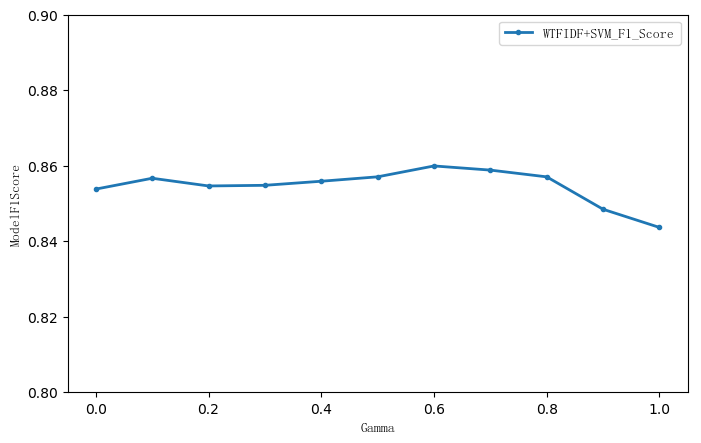

In [37]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simfang.ttf')


f1_wtfidf={0.0:0.85381,0.1:0.85668,0.2:0.85464,0.3:0.85481,0.4:0.85589,0.5:0.85706,0.6:0.85994,0.7:0.85884,0.8:0.85705,0.9:0.84846,1.0:0.84365}
f1_wtfidf_values=[i for i in f1_wtfidf.values()]
f1_wtfidf_keys=[i for i in f1_wtfidf.keys()]

f1_bow=[0.6674 for i in range(len(f1_wtfidf_keys))]
f1_tfidf=[0.7998 for i in range(len(f1_wtfidf_keys))]

plt.figure(figsize=(8,5),dpi=100)
plt.plot(f1_wtfidf_keys,f1_wtfidf_values,label="WTFIDF+SVM_F1_Score",marker=".",linewidth=2)
# plt.plot(f1_wtfidf_keys,f1_bow,label="BOW+SVM_F1_Score",linewidth=2)
# plt.plot(f1_wtfidf_keys,f1_tfidf,label="TFIDF+SVM_F1_Score",linewidth=2)


plt.ylim(0.8,0.9)
plt.xlabel('Gamma', fontproperties=my_font)
plt.ylabel('ModelF1Score', fontproperties=my_font)
plt.legend(prop=my_font)